In [11]:
# Importar las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [12]:
# 1. CARGA del dataset
try:
    df = pd.read_csv('Dataset_Loja_Preprocesado.csv')
    print("Dataset cargado.")
except:
    print("Error de carga.")

Dataset cargado.


Entrenando modelo optimizado (Fase 5)...

--- LISTA FINAL DEPURADA PARA AUDITORÍA ---
Se han exportado 26320 casos de Alta Prioridad.


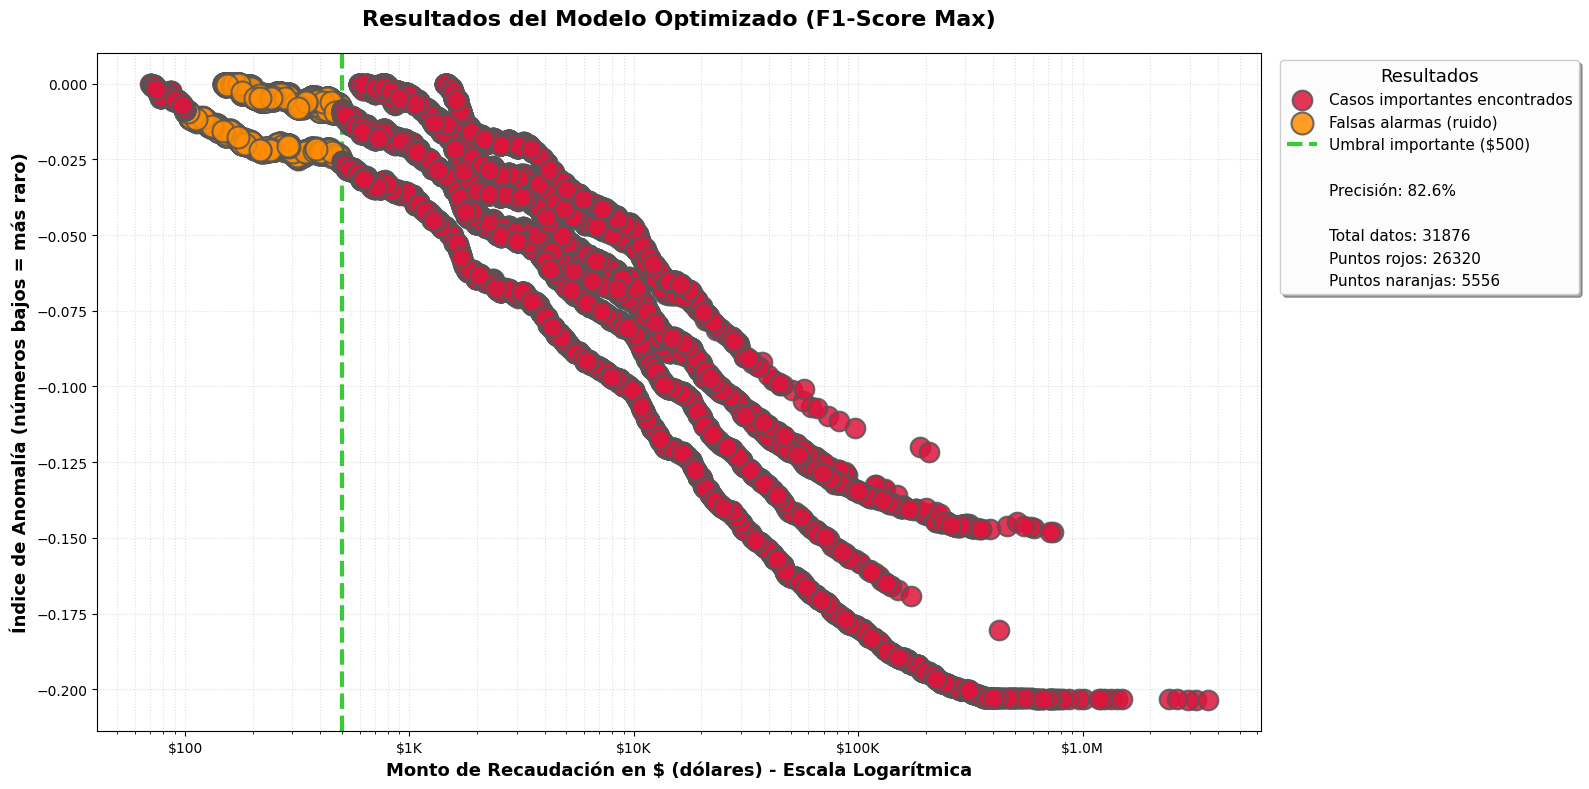

In [ ]:
# Importaciones necesarias (por si acaso no están cargadas arriba)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from matplotlib.ticker import FuncFormatter

# 2. CARACTERÍSTICAS
X_work = df.copy()
mapeo = {'NO TIENE': 0, 'PERSONAS NATURALES': 1, 'SOCIEDADES': 2}
X_work['TIPO_CODIFICADO'] = X_work['TIPO_CONTRIBUYENTE'].map(mapeo).fillna(0)
X_work['VALOR_LOG'] = np.log1p(X_work['VALOR_RECAUDADO'])

# Variables de Alto Contraste
X_work['TIPO_PONDERADO'] = X_work['TIPO_CODIFICADO'] * 8.0 
X_work['VALOR_DESV'] = (X_work['VALOR_RECAUDADO'] - X_work['VALOR_RECAUDADO'].mean()) / X_work['VALOR_RECAUDADO'].std()
X_work['TIPO_VALOR_INT'] = X_work['TIPO_PONDERADO'] * (X_work['VALOR_LOG'] + 1)

cols = ['VALOR_LOG', 'TIPO_PONDERADO', 'CLUSTER_GEO', 'VALOR_DESV', 'TIPO_VALOR_INT']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_work[cols])

# ==============================================================================
# 3. ENTRENAMIENTO (OPTIMIZADO FASE 5)
# ==============================================================================
print("Entrenando modelo optimizado (Fase 5)...")

# Aquí aplicamos los parámetros ganadores del Grid Search:
iso = IsolationForest(
    n_estimators=500,        # Estabilidad mejorada
    contamination=0.18,      # Ajustado al volumen real de anomalía
    max_features=1,       
    max_samples='auto',
    random_state=42, 
    n_jobs=-1
)

# PREDICCIÓN "CRUDA" (La inteligencia pura del modelo)
X_work['ANOMALIA_RAW'] = iso.fit_predict(X_scaled)
X_work['SCORE'] = iso.decision_function(X_scaled)

# 4. DEFINICIÓN DE "VERDAD" (GROUND TRUTH) PARA EVALUAR
# Criterio de Auditoría: ¿Qué es lo que REALMENTE nos importa?
# A. Élite Fiscal (> $500)
# B. Riesgo Sociedades (Sociedad pagando < $100)
es_elite = X_work['VALOR_RECAUDADO'] > 500
es_riesgo = (X_work['TIPO_CODIFICADO'] == 2) & (X_work['VALOR_RECAUDADO'] <= 100)

X_work['TARGET_REAL'] = (es_elite | es_riesgo).astype(int)

# 5. CÁLCULO DE LA PRECISIÓN REAL (MODELO CRUDO)
# Evaluamos qué tan bien lo hizo la IA sin ayuda humana
anomalos_raw = X_work[X_work['ANOMALIA_RAW'] == -1] # Lo que el modelo creyó que era raro
aciertos_raw = anomalos_raw[anomalos_raw['TARGET_REAL'] == 1] # Lo que realmente era importante

precision_real = len(aciertos_raw) / len(anomalos_raw) if len(anomalos_raw) > 0 else 0

# 6. GENERACIÓN DE LISTA FINAL (Aquí sí aplicamos limpieza para el usuario)
X_work['RELEVANCIA'] = 'RUIDO'
X_work.loc[(X_work['ANOMALIA_RAW'] == -1) & (X_work['TARGET_REAL'] == 1), 'RELEVANCIA'] = 'ALTA PRIORIDAD'

df_final = X_work[X_work['RELEVANCIA'] == 'ALTA PRIORIDAD'].sort_values('SCORE')

print(f"\n--- LISTA FINAL DEPURADA PARA AUDITORÍA ---")
print(f"Se han exportado {len(df_final)} casos de Alta Prioridad.")

# ============================================================================
# GRÁFICO ÚNICO: ENTENDIBLE PARA CUALQUIER PERSONA
# ============================================================================
fig, ax = plt.subplots(figsize=(16, 8))

anomalos_plot = X_work[X_work['ANOMALIA_RAW'] == -1].copy()

# Separar casos importantes de ruido
casos_importantes = anomalos_plot[anomalos_plot['TARGET_REAL'] == 1]
ruido = anomalos_plot[anomalos_plot['TARGET_REAL'] == 0]

# Calcular totales
total_general = len(anomalos_plot)
total_rojo = len(casos_importantes)
total_naranja = len(ruido)

# MEJORAS VISUALES
# 1. Graficar primero los puntos rojos para que no se superpongan
# 2. Aumentar significativamente tamaño y opacidad de naranjas
# 3. Usar escala logarítmica para mejor distribución visual
ax.scatter(casos_importantes['VALOR_RECAUDADO'], casos_importantes['SCORE'], 
           color='#DC143C', s=200, alpha=0.85, label='Casos importantes encontrados', 
           edgecolors='#555555', linewidth=1.5, zorder=3)

ax.scatter(ruido['VALOR_RECAUDADO'], ruido['SCORE'], 
           color='#FF8C00', s=250, alpha=0.85, label='Falsas alarmas (ruido)', 
           edgecolors='#555555', linewidth=1.5, zorder=2)

# Línea de referencia
ax.axvline(x=500, color='#32CD32', linestyle='--', linewidth=3, label='Umbral importante ($500)', zorder=1)

# ESCALA LOGARÍTMICA
ax.set_xscale('log')

# Formateador para mostrar los valores reales en dólares
def format_currency(x, p):
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.0f}K'
    else:
        return f'${x:.0f}'

ax.xaxis.set_major_formatter(FuncFormatter(format_currency))

ax.set_xlabel('Monto de Recaudación en $ (dólares) - Escala Logarítmica', fontsize=13, weight='bold')
ax.set_ylabel('Índice de Anomalía (números bajos = más raro)', fontsize=13, weight='bold')
ax.set_title(f'Resultados del Modelo Optimizado (F1-Score Max)', fontsize=16, weight='bold', pad=20)
ax.grid(True, alpha=0.4, linestyle=':', which='both')

# Leyenda FUERA del gráfico con estadísticas mejorada
handles, labels = ax.get_legend_handles_labels()

# Crear espaciadores y texto informativo
handles.append(plt.Line2D([0], [0], color='none', label=''))
handles.append(plt.Line2D([0], [0], color='none', label=f'Precisión: {precision_real*100:.1f}%', linewidth=0, marker=''))
handles.append(plt.Line2D([0], [0], color='none', label=''))
handles.append(plt.Line2D([0], [0], color='none', label=f'Total datos: {total_general}', linewidth=0, marker=''))
handles.append(plt.Line2D([0], [0], color='none', label=f'Puntos rojos: {total_rojo}', linewidth=0, marker=''))
handles.append(plt.Line2D([0], [0], color='none', label=f'Puntos naranjas: {total_naranja}', linewidth=0, marker=''))

ax.legend(handles=handles, loc='upper left', bbox_to_anchor=(1.01, 1), fontsize=11, 
          framealpha=0.98, title='Resultados', title_fontsize=13, frameon=True, fancybox=True, shadow=True)

plt.tight_layout()
plt.show()

Resultados de la Evaluación (Fase 5):
------------------------------------------------------
Accuracy (Exactitud Global): 0.7533 (75.33%)
Precision (Precisión):       0.8257 (82.57%) -> Cuántos de los detectados eran realmente anomalías
Recall (Sensibilidad):       0.4234 (42.34%) -> Cuántas de las anomalías reales encontró el modelo
------------------------------------------------------

Reporte de Clasificación Completo:
              precision    recall  f1-score   support

      Normal       0.74      0.95      0.83    105621
    Anomalía       0.83      0.42      0.56     62164

    accuracy                           0.75    167785
   macro avg       0.78      0.69      0.69    167785
weighted avg       0.77      0.75      0.73    167785



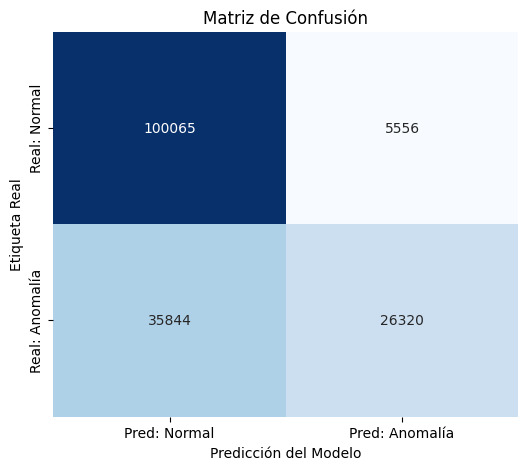

In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# === FASE 5: EVALUACIÓN (Corregido) ===

# 1. Definir variables con los nombres de TU notebook
# El modelo se llama 'iso', los datos escalados 'X_scaled' y la columna objetivo 'TARGET_REAL'
y_true = X_work['TARGET_REAL']
X_eval = X_scaled 

# 2. Generar predicciones
y_pred_raw = iso.predict(X_eval)

# 3. Mapeo de predicciones
# Isolation Forest devuelve: -1 (Anomalía) y 1 (Normal)
# Tu 'TARGET_REAL' es: 1 (Anomalía/Interés) y 0 (Normal)
# Convertimos: -1 -> 1, 1 -> 0
y_pred = [1 if x == -1 else 0 for x in y_pred_raw]

# 4. Calcular Métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

# 5. Imprimir Resultados
print("Resultados de la Evaluación (Fase 5):")
print("------------------------------------------------------")
print(f"Accuracy (Exactitud Global): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision (Precisión):       {precision:.4f} ({precision*100:.2f}%) -> Cuántos de los detectados eran realmente anomalías")
print(f"Recall (Sensibilidad):       {recall:.4f} ({recall*100:.2f}%) -> Cuántas de las anomalías reales encontró el modelo")
print("------------------------------------------------------")
print("\nReporte de Clasificación Completo:")
print(classification_report(y_true, y_pred, target_names=['Normal', 'Anomalía']))

# 6. Graficar Matriz de Confusión
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: Normal', 'Pred: Anomalía'],
            yticklabels=['Real: Normal', 'Real: Anomalía'])
plt.title('Matriz de Confusión')
plt.ylabel('Etiqueta Real')
plt.xlabel('Predicción del Modelo')
plt.show()